# Dashcam Vehicle Identification Using CNNs and Model Compression

Report by: Ryan Baker (10111414) and Nathalie Drzewiecki (30090300)

## Summary
In this project, we utilize convolutional neural networks (CNNs) to complete a car make-model classification task based off single RGB images. Initially, the intent was to compare the accuracy and performance of a traditional large neural network, AlexNet, to a more novel and compressed network, MobileNet. Unfortunately, the project proceeded with difficulty, and led to explorations of the dataset, hyper-parameters and models in an effort to reach an accuracy of over 90%. After much work in this area, the final models only reached a validation accuracy of around 50%. Finally, despite the lack of performance in the final models, the effects of iterative pruning and quantization were explored with compression applied to the MobileNet model. In conclusion, we identified the major obstacle in car make-model classfication to be the dataset itself. While a large and comprehensive dataset seems ideal, the effects of unbalanced classes with varying numbers of images as well as the granular classification of makes and models by year lead to various challenges within the project.

## Problem Statement and Use Case

With the common adoption of dashcam devices in vehicles, thousands of hours of road footage are now easy to access, but without any practical use beyond immediate security concerns (eg. recording a road accident). The implementation of a ML model gives this footage additional practical use. Therefore, the purpose of this study is to explore the feasibility of a mobile processing unit (such as a raspberry pi) that could process dashcam footage. A large data set ("Vehicle Make and Model Recognition Database"; abbrev. "VMMRdb") will be used to first attempt to develop an accurate make-model identifier. Once an accurate model is developed, we will attempt to compress the model to a practical size/complexity for edge deployment. Potential applications of the model could be statistics about vehicles, dates/times of encounters, and may be useful in the policing, surveillance, security, or insurance fields.

## Dataset
The data base chosen is the VMMRdb [1], comprised of 291,752 images covering models manufactured between 1950 and 2016. It includes different imaging devices, various view angles, random alignment within the image, and images with irrelevant backgrounds. The data comes from 712 areas within the United States and covers “all 412 subdomains”. The dataset was originally created for developing robust ML models in real life scenarios for traffic surveillance. This data set was chosen to to its large diversity of images, and most accurately represents the variability of vehicles a make/model/year classifier could encounter on the road, but also the frequency (eg. common models like 

A downloadable version of the dataset was found at https://www.kaggle.com/datasets/abhishektyagi001/vehicle-make-model-recognition-dataset-vmmrdb

## Proposed Methodology
We propose a solution utilizing a Convolutional Neural Network, which will classify car models based off single RGB images. The size of the model will be optimized in terms of number of layers, kernel sizes, stride sizes, and other parameters. Additionally, the model will be pruned and quantized for size reduction. 

Two architectures will be explored and compared: AlexNet 

## Project Code and Discussion

## VMMRdb and AlexNet

### Mount Colab Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Extracting VMMRdb Dataset

In [ ]:
import os
import shutil
shutil.unpack_archive("/content/drive/MyDrive/endg511project/VMMRdb.zip", "/content/")

Delete empty folders

In [ ]:
!find /content/VMMRdb/ -size  0 -print -delete

In [ ]:
num_classes = len(os.listdir("/content/VMMRdb/"))
print(num_classes)

8174


### Train AlexNet with VMMRdb Dataset

In [ ]:
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
import functools

DIRPATH = '/content/VMMRdb/'
num_classes = len(os.listdir(DIRPATH))
print(f"Number of classes: {num_classes}")

Number of classes: 8174


In [ ]:
train_alexvmmrdb, test_alexvmmrdb = tf.keras.utils.image_dataset_from_directory(
    DIRPATH,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=[227,227],
    label_mode='int')

Found 277231 files belonging to 8174 classes.
Using 221785 files for training.
Using 55446 files for validation.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout,Input, AveragePooling2D, Activation,Conv2D, MaxPooling2D, BatchNormalization,Concatenate
alexmodel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# printing the model summary 
alexmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
#Call back 1: 
base_learning_rate = 0.001
callback_1=tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', min_delta=0.005, patience=6, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

#call back 2: 
callback_2= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
    patience=4,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

callback_list=[callback_1,callback_2]

#compiling our Model for datasert
alexmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# training the model and saving the model components history to history variable
history = alexmodel.fit(train_alexvmmrdb, epochs=30, validation_data=test_alexvmmrdb,callbacks=callback_list)

Epoch 1/30
6931/6931 [==============================] - 147s 19ms/step - loss: 8.5228 - accuracy: 0.0028 - val_loss: 8.2557 - val_accuracy: 0.0031 - lr: 0.0010
Epoch 2/30
6931/6931 [==============================] - 129s 19ms/step - loss: 8.1687 - accuracy: 0.0032 - val_loss: 8.1656 - val_accuracy: 0.0031 - lr: 0.0010
Epoch 3/30
6931/6931 [==============================] - 131s 19ms/step - loss: 8.1117 - accuracy: 0.0032 - val_loss: 8.1536 - val_accuracy: 0.0031 - lr: 0.0010
Epoch 4/30
6931/6931 [==============================] - 130s 19ms/step - loss: 8.0981 - accuracy: 0.0032 - val_loss: 8.1534 - val_accuracy: 0.0031 - lr: 0.0010
Epoch 5/30
6931/6931 [==============================] - 130s 19ms/step - loss: 8.0950 - accuracy: 0.0032 - val_loss: 8.1552 - val_accuracy: 0.0031 - lr: 0.0010
Epoch 6/30
6931/6931 [==============================] - 130s 19ms/step - loss: 8.0942 - accuracy: 0.0032 - val_loss: 8.1571 - val_accuracy: 0.0031 - lr: 0.0010
Epoch 7/30
6931/6931 [==================

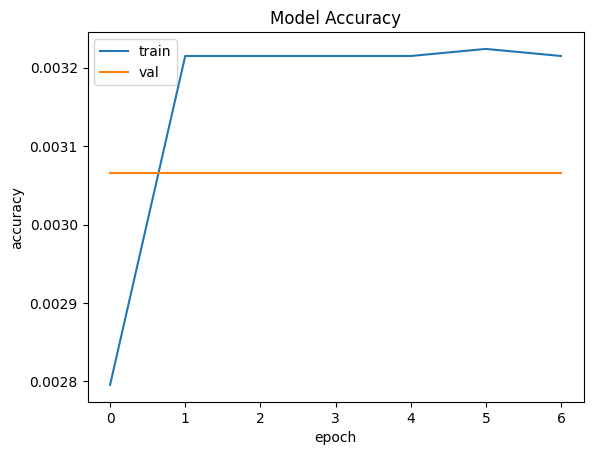

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Given the poor performance of this model, we will try to use `SparseTopKCategoricalAccuracy` as a metric instead of accuracy. Given the large number of classes, this may help improve this initial model's performance by relaxing the .

Determining how many 'k' classes to use

In [ ]:
import pandas as pd
data = []
for dir in os.listdir('./VMMRdb/'):
  dir_data = dir.split("_")[:2]
  data.append(dir_data)

df = pd.DataFrame(data)
df = df.groupby([0, 1]).size().reset_index(name='frequency')
print(df)
print(f'Average number of classes for unique make-models: {df["frequency"].mean()}')
print(f'Standard deviation of number of classes for unique make-models: {df["frequency"].std()}')
  

          0        1  frequency
0     acura       cl          6
1     acura       el          3
2     acura      ilx          1
3     acura  integra         16
4     acura   legend         11
..      ...      ...        ...
959   volvo     xc60          3
960   volvo     xc70         13
961   volvo     xc90         10
962  willys     cj2a          1
963  willys     cj3b          1

[964 rows x 3 columns]
Average number of classes for unique make-models: 8.479253112033195
Standard deviation of number of classes for unique make-models: 10.840416331158888


Given the large standard deviation of classes, using two standard deviations should accomodate more of each unique make/model than using just the mean for a k value (therefore, k=22 will be used).

In [ ]:
#Call back 1: 
base_learning_rate = 0.001
callback_1=tf.keras.callbacks.EarlyStopping(
    monitor='sparse_top_k_categorical_accuracy', min_delta=0.005, patience=6, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

#call back 2: 
callback_2= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
    patience=4,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

callback_list=[callback_1,callback_2]

#compiling our Model for datasert
alexmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(k=22)])

# training the model and saving the model components history to history variable
history = alexmodel.fit(train_alexvmmrdb, epochs=30, validation_data=test_alexvmmrdb,callbacks=callback_list)

Epoch 1/30
6931/6931 [==============================] - 130s 18ms/step - loss: 8.1708 - sparse_top_k_categorical_accuracy: 0.0385 - val_loss: 8.1769 - val_sparse_top_k_categorical_accuracy: 0.0377 - lr: 0.0010
Epoch 2/30
6931/6931 [==============================] - 124s 18ms/step - loss: 8.1200 - sparse_top_k_categorical_accuracy: 0.0385 - val_loss: 8.1694 - val_sparse_top_k_categorical_accuracy: 0.0377 - lr: 0.0010
Epoch 3/30
6931/6931 [==============================] - 124s 18ms/step - loss: 8.1089 - sparse_top_k_categorical_accuracy: 0.0385 - val_loss: 8.1685 - val_sparse_top_k_categorical_accuracy: 0.0377 - lr: 0.0010
Epoch 4/30
6931/6931 [==============================] - 127s 18ms/step - loss: 8.1054 - sparse_top_k_categorical_accuracy: 0.0385 - val_loss: 8.1687 - val_sparse_top_k_categorical_accuracy: 0.0377 - lr: 0.0010
Epoch 5/30
6931/6931 [==============================] - 127s 18ms/step - loss: 8.1040 - sparse_top_k_categorical_accuracy: 0.0384 - val_loss: 8.1691 - val_spars

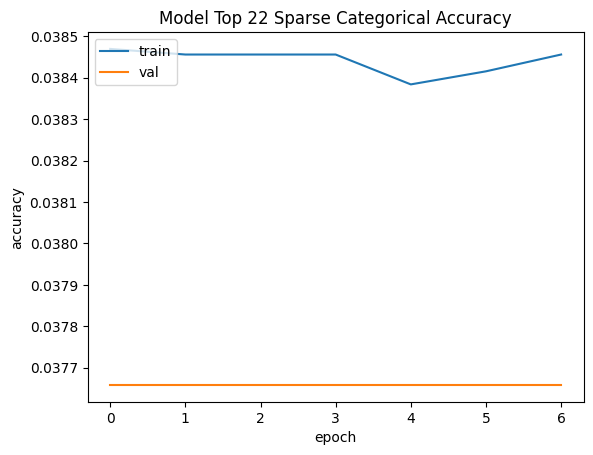

In [ ]:
plt.plot(history.history['sparse_top_k_categorical_accuracy'])
plt.plot(history.history['val_sparse_top_k_categorical_accuracy'])
plt.title('Model Top 22 Sparse Categorical Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Try with k=200 to see if any decent accuracy can be obtained

In [ ]:
#Call back 1: 
base_learning_rate = 0.001
callback_1=tf.keras.callbacks.EarlyStopping(
    monitor='sparse_top_k_categorical_accuracy', min_delta=0.005, patience=6, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

#call back 2: 
callback_2= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
    patience=4,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

callback_list=[callback_1,callback_2]

#compiling our Model for datasert
alexmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(k=200)])

# training the model and saving the model components history to history variable
history = alexmodel.fit(train_alexvmmrdb, epochs=30, validation_data=test_alexvmmrdb,callbacks=callback_list)

Epoch 1/30
6931/6931 [==============================] - 132s 18ms/step - loss: 8.1638 - sparse_top_k_categorical_accuracy: 0.1368 - val_loss: 8.2125 - val_sparse_top_k_categorical_accuracy: 0.1363 - lr: 0.0010
Epoch 2/30
6931/6931 [==============================] - 126s 18ms/step - loss: 8.1451 - sparse_top_k_categorical_accuracy: 0.1369 - val_loss: 8.2063 - val_sparse_top_k_categorical_accuracy: 0.1365 - lr: 0.0010
Epoch 3/30
6931/6931 [==============================] - 126s 18ms/step - loss: 8.1373 - sparse_top_k_categorical_accuracy: 0.1368 - val_loss: 8.2020 - val_sparse_top_k_categorical_accuracy: 0.1365 - lr: 0.0010
Epoch 4/30
6931/6931 [==============================] - 126s 18ms/step - loss: 8.1318 - sparse_top_k_categorical_accuracy: 0.1369 - val_loss: 8.1989 - val_sparse_top_k_categorical_accuracy: 0.1365 - lr: 0.0010
Epoch 5/30
6931/6931 [==============================] - 127s 18ms/step - loss: 8.1279 - sparse_top_k_categorical_accuracy: 0.1368 - val_loss: 8.1963 - val_spars

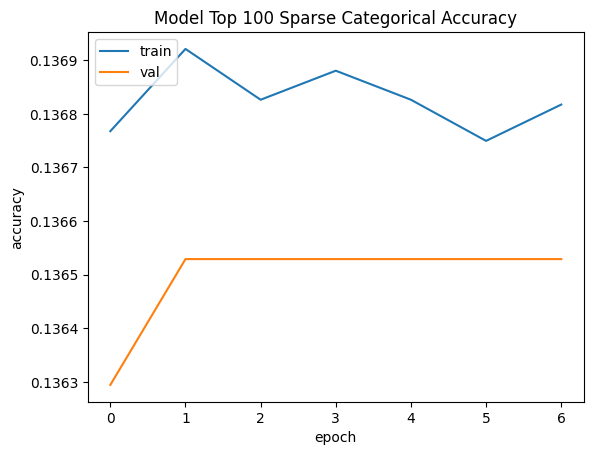

In [ ]:
plt.plot(history.history['sparse_top_k_categorical_accuracy'])
plt.plot(history.history['val_sparse_top_k_categorical_accuracy'])
plt.title('Model Top 200 Sparse Categorical Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Since we are still only trying to get a good performing **initial** model what we can then prune/quantize, given the poor performance thus far, the large number of classes, and the few number of images per class, it may be better to combine classes and attempt to retrain.

The script below combines make/model/year classes into make/model classes, and then deletes combined classes that have fewer than 100 images. This should reduce the number of classes by approximately 20x, and also increase the number of images by approximately 10x. Additionally, the year-to-year changes of the same make/model is assumed to be insignificant, so this should substantially improve the model performance when retraining.

In [ ]:
def make_dir(path_to_dir):
    if os.path.exists(path_to_dir):
        return path_to_dir
    else:
        os.mkdir(path_to_dir)
        return path_to_dir

OLD_DIR = '/content/VMMRdb/'
NEW_DIR = make_dir('/content/VMMRdb_reduced_classes/')

for i, dir in enumerate(os.listdir(OLD_DIR)):
    new_file_dir = make_dir(NEW_DIR+"_".join(dir.split("_")[:2]))
    for j, file in enumerate(os.listdir(OLD_DIR+'/'+dir)):
        old_file_loc = OLD_DIR+dir+'/'+file
        new_file_loc = new_file_dir + '/' + file
        shutil.move(old_file_loc, new_file_loc)

# delete directories with fewer than 100 files
min_file_count = 100

for dir in os.listdir(NEW_DIR):
    subdir = NEW_DIR+'/'+dir
    file_count = len(os.listdir(subdir))
    if file_count < min_file_count:
        shutil.rmtree(subdir)

# delete old directory of empty folders
shutil.rmtree(OLD_DIR)

In [ ]:
DIRPATH = NEW_DIR
num_classes = len(os.listdir(DIRPATH))
print(num_classes)

363


### Train AlexNet with VMMRdb Dataset After Combining 'Year' Classes

In [ ]:
train_alexvmmrdb, test_alexvmmrdb = tf.keras.utils.image_dataset_from_directory(
    DIRPATH,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=[227,227],
    label_mode='int')

Found 262640 files belonging to 363 classes.
Using 210112 files for training.
Using 52528 files for validation.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout,Input, AveragePooling2D, Activation,Conv2D, MaxPooling2D, BatchNormalization,Concatenate
alexmodel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# printing the model summary 
alexmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_5 (Batc  (None, 55, 55, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_6 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                      

In [ ]:
#Call back 1: 
base_learning_rate = 0.001
callback_1=tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', min_delta=0.005, patience=6, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

#call back 2: 
callback_2= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
    patience=4,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

callback_list=[callback_1,callback_2]

#compiling our Model for datasert
alexmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# training the model and saving the model components history to history variable
history = alexmodel.fit(train_alexvmmrdb, epochs=30, validation_data=test_alexvmmrdb,callbacks=callback_list)

Epoch 1/30
6566/6566 [==============================] - 119s 17ms/step - loss: 5.6290 - accuracy: 0.0304 - val_loss: 5.2576 - val_accuracy: 0.0338 - lr: 0.0010
Epoch 2/30
6566/6566 [==============================] - 113s 17ms/step - loss: 5.2664 - accuracy: 0.0339 - val_loss: 5.2565 - val_accuracy: 0.0338 - lr: 0.0010
Epoch 3/30
6566/6566 [==============================] - 113s 17ms/step - loss: 5.2575 - accuracy: 0.0339 - val_loss: 5.2564 - val_accuracy: 0.0338 - lr: 0.0010
Epoch 4/30
6566/6566 [==============================] - 113s 17ms/step - loss: 5.2565 - accuracy: 0.0339 - val_loss: 5.2561 - val_accuracy: 0.0338 - lr: 0.0010
Epoch 5/30
6566/6566 [==============================] - 113s 17ms/step - loss: 5.2609 - accuracy: 0.0339 - val_loss: 16143.0947 - val_accuracy: 0.0340 - lr: 0.0010
Epoch 6/30
6566/6566 [==============================] - 113s 17ms/step - loss: 5.2568 - accuracy: 0.0339 - val_loss: 542.7129 - val_accuracy: 0.0338 - lr: 0.0010
Epoch 7/30
6566/6566 [============

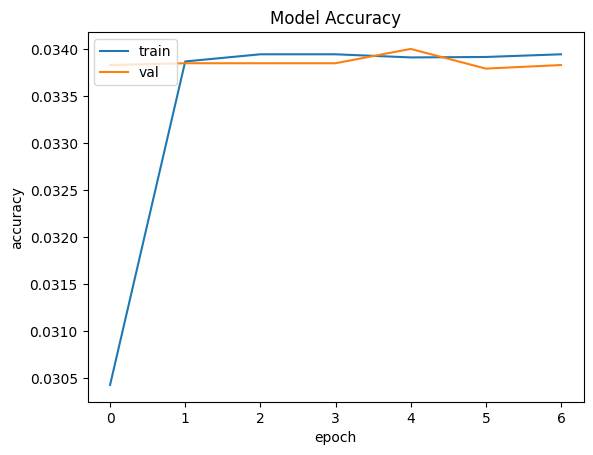

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

As only 3.4% accuracy was attained, using top 10 class accuracy may improve the results. *It should be noted that by using a `top k` metric with this many reduced classes, it's possible (and even likely) that a class within the 'top k' may not even be the same make of vehicle*. However, for the purposes of experimentation and in order to strive for a higher accuracy, this test was conducted.

In [ ]:
#Call back 1: 
base_learning_rate = 0.001
callback_1=tf.keras.callbacks.EarlyStopping(
    monitor='sparse_top_k_categorical_accuracy', min_delta=0.005, patience=6, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

#call back 2: 
callback_2= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
    patience=4,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

callback_list=[callback_1,callback_2]

#compiling our Model for datasert
alexmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10)])

# training the model and saving the model components history to history variable
history = alexmodel.fit(train_alexvmmrdb, epochs=30, validation_data=test_alexvmmrdb,callbacks=callback_list)

Epoch 1/30
6566/6566 [==============================] - 122s 18ms/step - loss: 5.2580 - sparse_top_k_categorical_accuracy: 0.2137 - val_loss: 57.6710 - val_sparse_top_k_categorical_accuracy: 0.2159 - lr: 0.0010
Epoch 2/30
6566/6566 [==============================] - 117s 18ms/step - loss: 5.2559 - sparse_top_k_categorical_accuracy: 0.2139 - val_loss: 55.5179 - val_sparse_top_k_categorical_accuracy: 0.2159 - lr: 0.0010
Epoch 3/30
6566/6566 [==============================] - 115s 17ms/step - loss: 5.2556 - sparse_top_k_categorical_accuracy: 0.2142 - val_loss: 53.9903 - val_sparse_top_k_categorical_accuracy: 0.2158 - lr: 0.0010
Epoch 4/30
6566/6566 [==============================] - 115s 17ms/step - loss: 5.2548 - sparse_top_k_categorical_accuracy: 0.2141 - val_loss: 59.3962 - val_sparse_top_k_categorical_accuracy: 0.2158 - lr: 0.0010
Epoch 5/30
6566/6566 [==============================] - 115s 17ms/step - loss: 5.2548 - sparse_top_k_categorical_accuracy: 0.2141 - val_loss: 54.2885 - val_

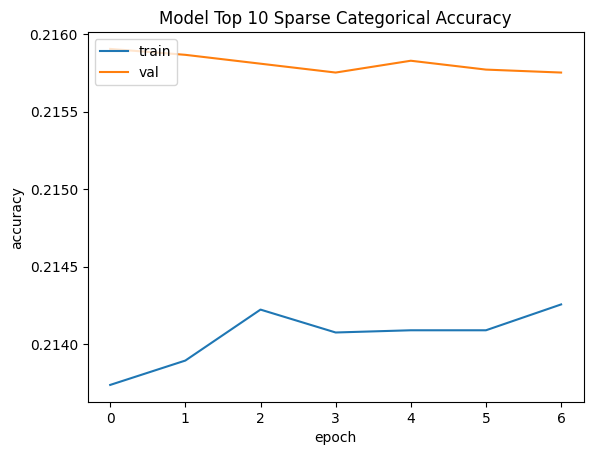

In [ ]:
plt.plot(history.history['sparse_top_k_categorical_accuracy'])
plt.plot(history.history['val_sparse_top_k_categorical_accuracy'])
plt.title('Model Top 10 Sparse Categorical Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Train AlexNet with VMMRdb Dataset After Combining 'Model' Classes

As a final attempt to use the AlexNet model with this data set, we will further combine the classes into make only. This will significantly impact the use case, however the purpose of this study was to investigate the feasibility of identifying vehicles in real time from dashcam footage. There could still be reasonable use cases for identifying only the make of vehicles.

If this model also has low accuracy, the error may be related to the AlexNet architecture or the images themselves. Given the high variety of images (various sources, various backgrounds, etc), it's possible that the AlexNet architecure isn't very good at identifying the key features of this data set or that the images have too much 'noise' for a CNN to identify the distinguishing features.

In [ ]:
def make_dir(path_to_dir):
    if os.path.exists(path_to_dir):
        return path_to_dir
    else:
        os.mkdir(path_to_dir)
        return path_to_dir

OLD_DIR = '/content/VMMRdb_reduced_classes/'
NEW_DIR = make_dir('/content/VMMRdb_make_only/')

for i, dir in enumerate(os.listdir(OLD_DIR)):
    new_file_dir = make_dir(NEW_DIR+"_".join(dir.split("_")[:1]))
    for j, file in enumerate(os.listdir(OLD_DIR+'/'+dir)):
        old_file_loc = OLD_DIR+dir+'/'+file
        new_file_loc = new_file_dir + '/' + file
        shutil.move(old_file_loc, new_file_loc)

# delete directories with fewer than 100 files
min_file_count = 100

for dir in os.listdir(NEW_DIR):
    subdir = NEW_DIR+'/'+dir
    file_count = len(os.listdir(subdir))
    if file_count < min_file_count:
        shutil.rmtree(subdir)

# delete old directory of empty folders
shutil.rmtree(OLD_DIR)

In [ ]:
DIRPATH = NEW_DIR
num_classes = len(os.listdir(DIRPATH))
print(num_classes)

41


In [ ]:
train_alexvmmrdb, test_alexvmmrdb = tf.keras.utils.image_dataset_from_directory(
    DIRPATH,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=[227,227],
    label_mode='int')

Found 262625 files belonging to 41 classes.
Using 210100 files for training.
Using 52525 files for validation.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout,Input, AveragePooling2D, Activation,Conv2D, MaxPooling2D, BatchNormalization,Concatenate
alexmodel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# printing the model summary 
alexmodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_10 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_11 (Bat  (None, 27, 27, 256)      1024      
 chNormalization)                                                
                                                      

In [ ]:
#Call back 1: 
base_learning_rate = 0.001
callback_1=tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', min_delta=0.005, patience=6, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

#call back 2: 
callback_2= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
    patience=4,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

callback_list=[callback_1,callback_2]

#compiling our Model for datasert
alexmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# training the model and saving the model components history to history variable
history = alexmodel.fit(train_alexvmmrdb, epochs=30, validation_data=test_alexvmmrdb,callbacks=callback_list)

Epoch 1/30
6566/6566 [==============================] - 121s 18ms/step - loss: 3.1978 - accuracy: 0.1456 - val_loss: 3.0159 - val_accuracy: 0.1523 - lr: 0.0010
Epoch 2/30
6566/6566 [==============================] - 116s 18ms/step - loss: 3.0235 - accuracy: 0.1499 - val_loss: 3.0155 - val_accuracy: 0.1523 - lr: 0.0010
Epoch 3/30
6566/6566 [==============================] - 115s 17ms/step - loss: 3.0223 - accuracy: 0.1505 - val_loss: 3.0155 - val_accuracy: 0.1523 - lr: 0.0010
Epoch 4/30
6566/6566 [==============================] - 116s 18ms/step - loss: 3.0214 - accuracy: 0.1510 - val_loss: 3.0153 - val_accuracy: 0.1523 - lr: 0.0010
Epoch 5/30
6566/6566 [==============================] - 115s 17ms/step - loss: 3.0563 - accuracy: 0.1508 - val_loss: 3.0150 - val_accuracy: 0.1523 - lr: 0.0010
Epoch 6/30
6566/6566 [==============================] - 114s 17ms/step - loss: 3.0275 - accuracy: 0.1510 - val_loss: 3.0150 - val_accuracy: 0.1523 - lr: 0.0010
Epoch 7/30
6566/6566 [==================

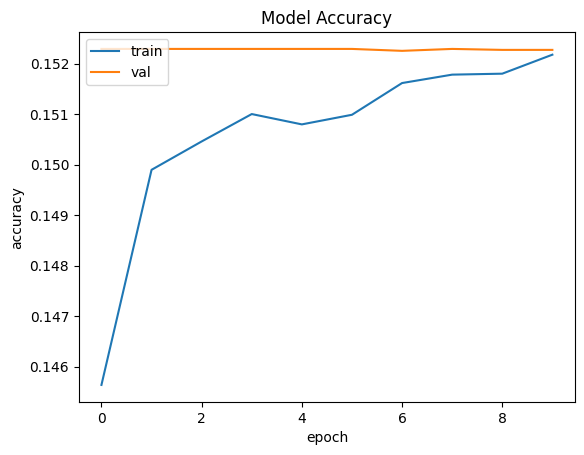

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Up until now, only AlexNet has been used as an architecture, and the latest attempt had only 41 classes with over 200,000 images for training (approx. 5,000 images per class) but still results in an unacceptable level of accuracy.

In researching other papers that cited this data set, it seems to be common practice for researchers to only use a small portion of the data set and/or combine classes into 'make/model' or 'make only' classes. The most common way this data set is utilized is by identifying the top classes with a certain number of images, and ignoring all other classes.

As a result, the next steps will be to use only the top `______` classes with the most amount of images, and a few other architechtures will be explored.

## Re-Analyzing VMMRdb for Classes With the Most Images

### Extracting Original Data Set (again; performed in a new runtime)

In [ ]:
import os
import shutil
from google.colab import drive

DIRPATH = "/content/VMMRdb/"

drive.mount('/content/drive/')
shutil.unpack_archive("/content/drive/MyDrive/endg511project/VMMRdb.zip", "/content/")
print(len(os.listdir(DIRPATH)))

Mounted at /content/drive/
8174


### VMMRdb Re-Analysis and Explanation of Next Steps

Reading Class Names and Number of Images into a Dataframe and sorting by Number of Images

In [ ]:
import pandas as pd

df = pd.DataFrame(columns=["class_name", "num_images"])
for classname in os.listdir(DIRPATH):
  number_of_images = len(os.listdir(DIRPATH+"/"+classname))
  df = pd.concat([df, pd.DataFrame({"class_name": [classname], "num_images": [number_of_images]})])

df = df.sort_values(by=["num_images"], ascending=False)
print(df)


              class_name num_images
0     ford_explorer_2002        883
0     nissan_altima_2005        716
0     ford_explorer_2003        584
0       honda_civic_2002        535
0     ford_explorer_2004        526
..                   ...        ...
0      nissan_200sx_1987          1
0       porsche_911_1974          1
0   pontiac_sunbird_2003          1
0     dodge_cummins_2000          1
0           bmw_528_2013          0

[8174 rows x 2 columns]


How many classes have 500 or more images?

In [ ]:
filter_num = 500
print(df[df["num_images"] >= filter_num])
print(f'\nNumber of classes with >={filter_num} images: {df[df["num_images"] > filter_num].shape[0]}')

           class_name num_images
0  ford_explorer_2002        883
0  nissan_altima_2005        716
0  ford_explorer_2003        584
0    honda_civic_2002        535
0  ford_explorer_2004        526
0   ford_mustang_2000        504

Number of classes with >=500 images: 6


This is probably too few classes. Try 400 or more classes.

In [ ]:
filter_num = 400
print(df[df["num_images"] >= filter_num])
print(f'\nNumber of classes with >={filter_num} images: {df[df["num_images"] > filter_num].shape[0]}')

                 class_name num_images
0        ford_explorer_2002        883
0        nissan_altima_2005        716
0        ford_explorer_2003        584
0          honda_civic_2002        535
0        ford_explorer_2004        526
0         ford_mustang_2000        504
0  chevrolet_silverado_2004        487
0         toyota_camry_2007        467
0        nissan_altima_2002        458
0  dodge_grand caravan_2005        447
0          honda_civic_1998        443
0         honda_accord_2000        440
0        nissan_altima_2003        438
0         honda_accord_1999        437
0     chevrolet_impala_2006        436
0          honda_civic_2001        434
0         honda_accord_1998        429
0         honda_accord_2003        420
0        nissan_altima_2006        419
0            ford_f150_2004        414
0          ford_taurus_2001        410
0         honda_accord_2005        409
0        nissan_altima_2008        408
0          ford_taurus_2003        405
0     volkswagen_jetta_20

Note that there are some classes with the same make/model but only differ by one year. This may be difficult for a ML model to discern between. If these make/model classes are combined, how many classes will be left?

In [ ]:
filtered_df = df[df["num_images"] >= filter_num].copy()
filtered_df.loc[:, "make_model"] = filtered_df["class_name"].str.split("_").str[:2].str.join("_")
df_make_model = filtered_df[["make_model", "num_images"]].groupby("make_model").sum()
print(df_make_model)
print(f'\nNumber of make/model classes after combining classes with >={filter_num} images: {df_make_model.shape[0]}')

                     num_images
make_model                     
chevrolet_impala            436
chevrolet_silverado         487
dodge_grand caravan         447
ford_explorer              1993
ford_f150                   414
ford_mustang                504
ford_taurus                 815
honda_accord               2135
honda_civic                1412
nissan_altima              2439
toyota_camry                467
volkswagen_jetta            402

Number of make/model classes after combining classes with >=400 images: 12


We will initially try using only classes that have >= 400 images, and combine them into make/model classes if performance is low.

Given that the use case is a mobile processing unit of dashcam footage, MobileNetV2 and MobileNetV3 (`MobileNetV3Large`) will be explored as the next architectures.

### Create Filtered Data Set

In [ ]:
NEW_DIR = '/content/VMMRdb_LrgImgCount/'
os.mkdir(NEW_DIR)

In [ ]:
# Loop through each folder in the directory
for folder in os.listdir(DIRPATH):
    # Check if the folder name exists in the specified column of the dataframe
    if folder in filtered_df["class_name"].values:
        # Create a new directory in the destination directory with the same name as the matching folder
        new_folder_path = os.path.join(NEW_DIR, folder)
        os.makedirs(new_folder_path, exist_ok=True)
        # Copy the images in the matching folder to the new directory
        src_folder_path = os.path.join(DIRPATH, folder)
        for file_name in os.listdir(src_folder_path):
            src_file_path = os.path.join(src_folder_path, file_name)
            dest_file_path = os.path.join(new_folder_path, file_name)
            shutil.copyfile(src_file_path, dest_file_path)

In [ ]:
print(f'rows of filtered dataframe: {filtered_df.shape[0]}')
print(f'number of classes in new directory: {len(os.listdir(NEW_DIR))}')

rows of filtered dataframe: 25
number of classes in new directory: 25


### Zip Filtered Dataset for later use.

In [ ]:
zip_filename = 'VMMRdb_LrgImgCount'
shutil.make_archive(os.path.join('/content/drive/MyDrive/endg511project/',zip_filename), 'zip', NEW_DIR)

'/content/drive/MyDrive/endg511project/VMMRdb_LrgImgCount.zip'

## Creating a Save Directory for Models

In [ ]:
SAVE_DIR = '/content/drive/MyDrive/endg511project/SavedModels/'

In [ ]:
os.mkdir(SAVE_DIR)

## Train MobileNetV2 with Filtered Datset

In [1]:
import os
import shutil
from google.colab import drive
import tensorflow as tf
from matplotlib import pyplot as plt

DIRPATH = '/content/VMMRdb_LrgImgCount/'
SAVE_DIR = '/content/drive/MyDrive/endg511project/SavedModels/'

drive.mount('/content/drive/')
shutil.unpack_archive("/content/drive/MyDrive/endg511project/VMMRdb_LrgImgCount.zip", DIRPATH)

num_classes = len(os.listdir(DIRPATH))
print(f"Number of Classes: {num_classes}")
for subdir in os.listdir(DIRPATH):
  print(f"Class: {subdir}, Count: {len(os.listdir(os.path.join(DIRPATH, subdir)))}")

Mounted at /content/drive/
Number of Classes: 25
Class: ford_explorer_2003, Count: 584
Class: honda_accord_2000, Count: 440
Class: ford_f150_2004, Count: 414
Class: honda_accord_1999, Count: 437
Class: ford_taurus_2001, Count: 410
Class: honda_accord_1998, Count: 429
Class: nissan_altima_2005, Count: 716
Class: ford_mustang_2000, Count: 504
Class: nissan_altima_2008, Count: 408
Class: ford_explorer_2002, Count: 883
Class: chevrolet_silverado_2004, Count: 487
Class: ford_explorer_2004, Count: 526
Class: nissan_altima_2003, Count: 438
Class: nissan_altima_2006, Count: 419
Class: volkswagen_jetta_2006, Count: 402
Class: honda_accord_2005, Count: 409
Class: honda_accord_2003, Count: 420
Class: honda_civic_2002, Count: 535
Class: chevrolet_impala_2006, Count: 436
Class: honda_civic_2001, Count: 434
Class: honda_civic_1998, Count: 443
Class: nissan_altima_2002, Count: 458
Class: toyota_camry_2007, Count: 467
Class: dodge_grand caravan_2005, Count: 447
Class: ford_taurus_2003, Count: 405


In [2]:
train_mobilenet, test_mobilenet = tf.keras.utils.image_dataset_from_directory(
    DIRPATH,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=[224,224],
    label_mode='int')

Found 11951 files belonging to 25 classes.
Using 9561 files for training.
Using 2390 files for validation.


Computing Class Weights

In [3]:
import numpy as np
from collections import Counter

# Get the class labels from the dataset
class_labels = train_mobilenet.class_names

# Get the number of images per class
num_images_per_class = []
for images, labels in train_mobilenet:
    for label in labels.numpy():
        num_images_per_class.append(label)
class_counts = Counter(num_images_per_class)

# Calculate class frequencies
total_num_images = sum(class_counts.values())
class_frequencies = []
for i in range(len(class_labels)):
    class_frequencies.append(class_counts[i] / total_num_images)

# Calculate class weights
max_frequency = max(class_frequencies)
class_weights = {}
for i in range(len(class_labels)):
    class_weights[i] = max_frequency / class_frequencies[i]

print(class_weights)

{0: 1.9744318181818186, 1: 1.7506297229219145, 2: 1.9146005509641875, 3: 1.0, 4: 1.4509394572025052, 5: 1.6951219512195124, 6: 2.068452380952381, 7: 1.759493670886076, 8: 2.1517027863777094, 9: 2.131901840490798, 10: 2.0028818443804037, 11: 1.9198895027624312, 12: 1.9522471910112362, 13: 2.0746268656716422, 14: 2.0746268656716422, 15: 1.9744318181818186, 16: 2.0562130177514795, 17: 1.6162790697674418, 18: 1.8733153638814017, 19: 1.9632768361581923, 20: 1.2477558348294435, 21: 2.165109034267913, 22: 2.131901840490798, 23: 1.8733153638814017, 24: 2.1060606060606064}


Creating the model

In [4]:
mobilev2model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    alpha=1.0,
    include_top=True,
    weights=None,
    input_tensor=None,
    pooling='max',
    classes=num_classes
)
mobilev2model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [10]:
# Call back 1: 
base_learning_rate = 1e-4
opt1 = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
callback_1=tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', min_delta=0, patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

# Call back 2: 
callback_2= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
    patience=4,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

callback_list=[callback_1, callback_2]

#compiling our Model for dataset
mobilev2model.compile(optimizer=opt1,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# training the model and saving the model components history to history variable
history = mobilev2model.fit(
    train_mobilenet,
    epochs=60,
    validation_data=test_mobilenet,
    class_weight=class_weights,
    callbacks=callback_list)

Epoch 1/60
299/299 [==============================] - 42s 51ms/step - loss: 1.3453 - accuracy: 0.7565 - val_loss: 4.7913 - val_accuracy: 0.1515 - lr: 1.0000e-04
Epoch 2/60
299/299 [==============================] - 15s 49ms/step - loss: 1.2569 - accuracy: 0.7710 - val_loss: 4.8691 - val_accuracy: 0.1410 - lr: 1.0000e-04
Epoch 3/60
299/299 [==============================] - 15s 49ms/step - loss: 1.0572 - accuracy: 0.8036 - val_loss: 5.7748 - val_accuracy: 0.1423 - lr: 1.0000e-04
Epoch 4/60
299/299 [==============================] - 15s 49ms/step - loss: 0.8951 - accuracy: 0.8420 - val_loss: 6.1853 - val_accuracy: 0.1393 - lr: 1.0000e-04
Epoch 5/60
299/299 [==============================] - 15s 49ms/step - loss: 0.7976 - accuracy: 0.8563 - val_loss: 5.8315 - val_accuracy: 0.1406 - lr: 1.0000e-04
Epoch 6/60
299/299 [==============================] - 15s 49ms/step - loss: 0.5434 - accuracy: 0.9074 - val_loss: 4.4600 - val_accuracy: 0.1749 - lr: 1.0000e-05
Epoch 7/60
299/299 [==============

Training was ran three consecutive times, and stopped early on the final two runs; approximately 150 epochs in total. This is the highest validation accuracy that could be achieved.

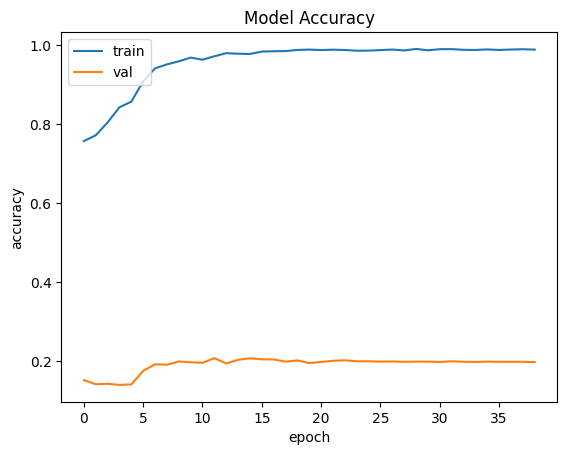

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

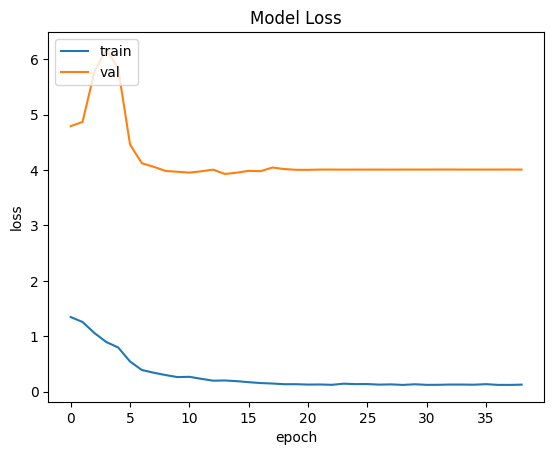

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
mobilev2model.save(os.path.join(SAVE_DIR,'mobileNetV2_noPretrain_noTuning.h5'))

## Train MobileNetV3 with Filtered Dataset

In [14]:
mobilev3model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224,224,3),
    alpha=1.0,
    include_top=True,
    weights=None,
    pooling='max'
)
mobilev3model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [20]:
# Call back 1: 
base_learning_rate = 1e-4
opt1 = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
callback_1=tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', min_delta=0, patience=4, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

# Call back 2: 
callback_2= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
    patience=4,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

callback_list=[callback_1, callback_2]

#compiling our Model for dataset
mobilev3model.compile(optimizer=opt1,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# training the model and saving the model components history to history variable
history = mobilev3model.fit(
    train_mobilenet,
    epochs=60,
    validation_data=test_mobilenet,
    class_weight=class_weights,
    callbacks=callback_list)

Epoch 1/60
299/299 [==============================] - 48s 60ms/step - loss: 0.4436 - accuracy: 0.9143 - val_loss: 6.7276 - val_accuracy: 0.0331 - lr: 1.0000e-04
Epoch 2/60
299/299 [==============================] - 17s 57ms/step - loss: 0.4489 - accuracy: 0.9089 - val_loss: 5.5325 - val_accuracy: 0.0347 - lr: 1.0000e-04
Epoch 3/60
299/299 [==============================] - 17s 57ms/step - loss: 0.4534 - accuracy: 0.9127 - val_loss: 4.7189 - val_accuracy: 0.0979 - lr: 1.0000e-04
Epoch 4/60
299/299 [==============================] - 17s 57ms/step - loss: 0.3895 - accuracy: 0.9252 - val_loss: 5.1645 - val_accuracy: 0.1025 - lr: 1.0000e-04
Epoch 5/60
299/299 [==============================] - 17s 57ms/step - loss: 0.3549 - accuracy: 0.9335 - val_loss: 4.8629 - val_accuracy: 0.1364 - lr: 1.0000e-04
Epoch 6/60
299/299 [==============================] - 17s 57ms/step - loss: 0.2848 - accuracy: 0.9445 - val_loss: 5.5299 - val_accuracy: 0.1552 - lr: 1.0000e-04
Epoch 7/60
299/299 [==============

Training was ran three consecutive times, and stopped early on all three runs; approximately 70 epochs in total. This is the highest validation accuracy that could be achieved.

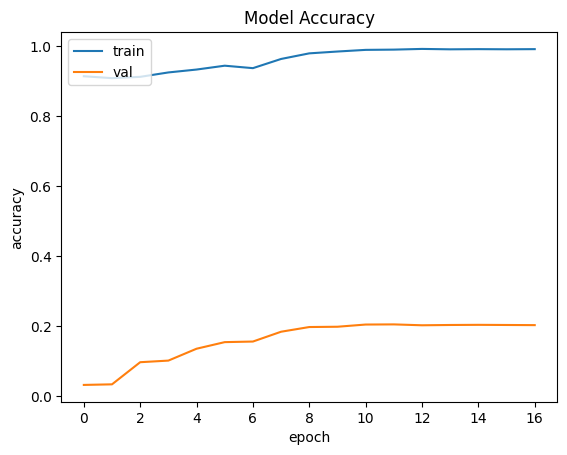

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

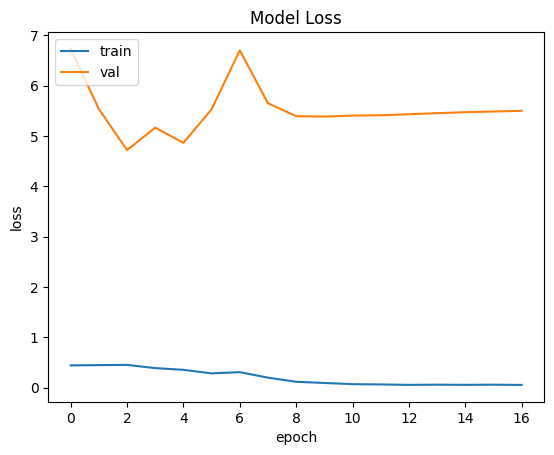

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
mobilev3model.save(os.path.join(SAVE_DIR,'mobileNetV3_noPretrain_noTuning.h5'))

## Train MobileNetV2 with Filtered Dataset and Data Augmentation, 128 Batch Size, Pretrained on ImageNet

In [13]:
import os
import shutil
from google.colab import drive
import tensorflow as tf
from matplotlib import pyplot as plt

DIRPATH = '/content/VMMRdb_LrgImgCount/'

drive.mount('/content/drive/')
shutil.unpack_archive("/content/drive/MyDrive/endg511project/VMMRdb_LrgImgCount.zip", DIRPATH)

num_classes = len(os.listdir(DIRPATH))
print(num_classes)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
25


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

# Training set
train_generator = train_datagen.flow_from_directory(
    DIRPATH,
    target_size=(224, 224),
    batch_size=128,
    class_mode='sparse',
    subset='training')

# Validation set
validation_generator = train_datagen.flow_from_directory(
    DIRPATH,
    target_size=(224, 224),
    batch_size=128,
    class_mode='sparse',
    subset='validation')

Found 9572 images belonging to 25 classes.
Found 2379 images belonging to 25 classes.


In [15]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

# Define MobileNetV2 model with pre-trained weights and excluding the final classification layer
mobilev2model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    alpha=1.0,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling='max'
)

# Define new output layer with softmax activation for `num_classes` classes
output_layer = Dense(num_classes, activation='softmax')(mobilev2model.output)

# Create a new model with the same input as the MobileNetV2 model and the new output layer
mobilev2model = Model(inputs=mobilev2model.input, outputs=output_layer)

# Print model summary
mobilev2model.summary()


9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                               

In [16]:
# Call back 1: 
base_learning_rate = 1e-5
opt1 = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
callback_1=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=4, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

# Call back 2: 
callback_2= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
    patience=4,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

callback_list=[callback_1, callback_2]

#compiling our Model for dataset
mobilev2model.compile(optimizer=opt1,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# training the model and saving the model components history to history variable
history = mobilev2model.fit(
    train_generator,
    epochs=60,
    validation_data=validation_generator,
    callbacks=callback_list)

Epoch 1/60
75/75 [==============================] - 185s 2s/step - loss: 8.2733 - accuracy: 0.0543 - val_loss: 8.0098 - val_accuracy: 0.0597 - lr: 1.0000e-05
Epoch 2/60
75/75 [==============================] - 157s 2s/step - loss: 5.7164 - accuracy: 0.0755 - val_loss: 7.5849 - val_accuracy: 0.0647 - lr: 1.0000e-05
Epoch 3/60
75/75 [==============================] - 156s 2s/step - loss: 5.0202 - accuracy: 0.1076 - val_loss: 7.0076 - val_accuracy: 0.0744 - lr: 1.0000e-05
Epoch 4/60
75/75 [==============================] - 156s 2s/step - loss: 4.5388 - accuracy: 0.1347 - val_loss: 6.6553 - val_accuracy: 0.0769 - lr: 1.0000e-05
Epoch 5/60
75/75 [==============================] - 157s 2s/step - loss: 4.1696 - accuracy: 0.1688 - val_loss: 6.1572 - val_accuracy: 0.0862 - lr: 1.0000e-05
Epoch 6/60
75/75 [==============================] - 157s 2s/step - loss: 3.9135 - accuracy: 0.1890 - val_loss: 5.7270 - val_accuracy: 0.0971 - lr: 1.0000e-05
Epoch 7/60
75/75 [==============================] - 

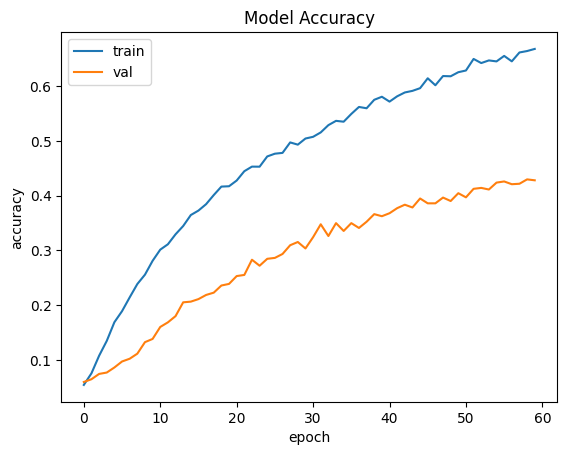

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

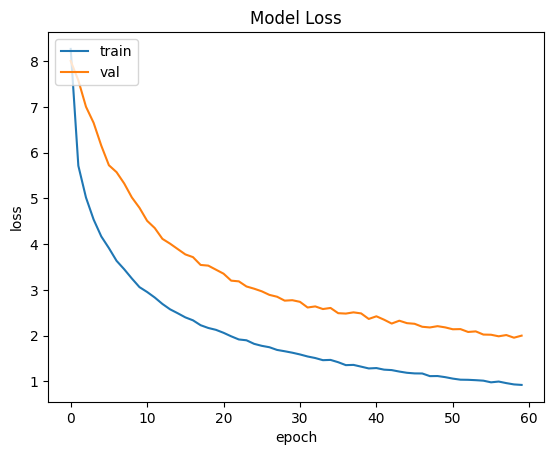

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
mobilev2model.save(os.path.join(SAVE_DIR,'mobileNetV2_PretrainImageNet_128BatchSize_DataAug.h5'))

## Train MobileNetV3 with Filtered Dataset and Data Augmentation, 128 Batch Size, Pretrained on ImageNet

Based on the [Keras Documentation](https://keras.io/api/applications/mobilenet/?fbclid=IwAR0vt7xKPFnnTNknJENQlR4YaHhcBDW3pUn8oACVwkoHNxOsJwqSizK1KNI), `MobileNetV3Large` was chosen as the version of MobileNetV3 to use, as pruning/quantization will be later applied.

In [20]:
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Define regularization
l2_reg = 0.001

# Load MobileNetV3Large model without top layer
mobilev3model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224,224,3),
    alpha=1.0,
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Add a new top layer to match number of classes
x = mobilev3model.output
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(l2_reg))(x)

# Create new model with the base model and new top layers
mobilev3model = tf.keras.models.Model(inputs=mobilev3model.input, outputs=output)

mobilev3model.summary()


12683000/12683000 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                           

In [21]:
# Call back 1: 
base_learning_rate = 1e-5
opt1 = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
callback_1=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=4, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

# Call back 2: 
callback_2= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
    patience=4,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

callback_list=[callback_1, callback_2]

#compiling our Model for dataset
mobilev3model.compile(optimizer=opt1,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# training the model and saving the model components history to history variable
history = mobilev3model.fit(
    train_generator,
    epochs=60,
    validation_data=validation_generator,
    callbacks=callback_list)

Epoch 1/60
75/75 [==============================] - 191s 2s/step - loss: 17.8301 - accuracy: 0.0487 - val_loss: 5.0050 - val_accuracy: 0.0383 - lr: 1.0000e-05
Epoch 2/60
75/75 [==============================] - 156s 2s/step - loss: 12.9007 - accuracy: 0.0542 - val_loss: 4.9525 - val_accuracy: 0.0383 - lr: 1.0000e-05
Epoch 3/60
75/75 [==============================] - 156s 2s/step - loss: 10.5733 - accuracy: 0.0581 - val_loss: 4.8971 - val_accuracy: 0.0383 - lr: 1.0000e-05
Epoch 4/60
75/75 [==============================] - 156s 2s/step - loss: 9.2136 - accuracy: 0.0663 - val_loss: 4.8459 - val_accuracy: 0.0383 - lr: 1.0000e-05
Epoch 5/60
75/75 [==============================] - 156s 2s/step - loss: 8.2128 - accuracy: 0.0710 - val_loss: 4.7744 - val_accuracy: 0.0387 - lr: 1.0000e-05
Epoch 6/60
75/75 [==============================] - 156s 2s/step - loss: 7.2915 - accuracy: 0.0762 - val_loss: 4.7317 - val_accuracy: 0.0374 - lr: 1.0000e-05
Epoch 7/60
75/75 [==============================]

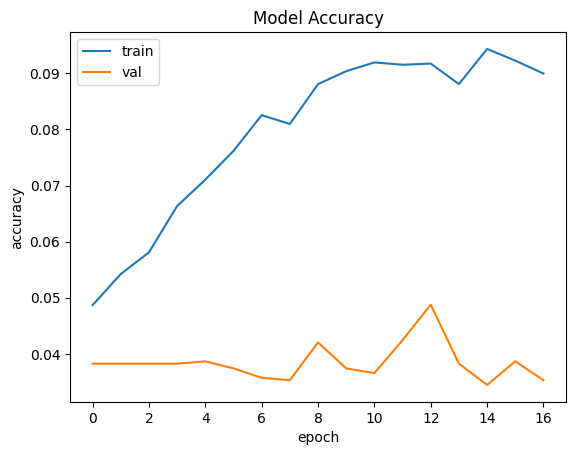

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

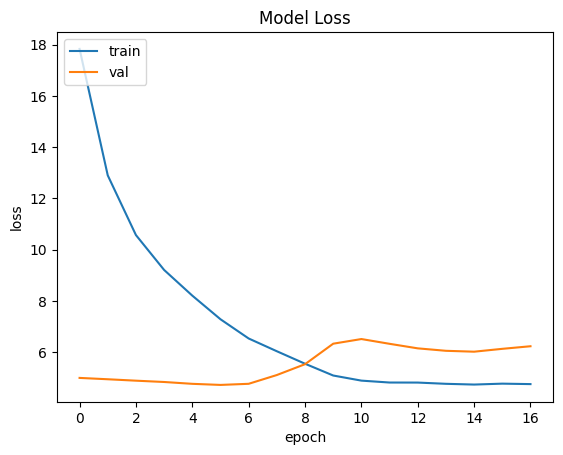

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
mobilev3model.save(os.path.join(SAVE_DIR,'mobileNetV3_PretrainImageNet_128BatchSize_DataAug.h5'))

## Reducing the Filtered Data Set to Make/Model

As none of the models to date have been able to provide a good level of accuracy, this will be the final attempt to modify the data set to something that either MobileNetV2 or MobileNetV3 can perform accurate predictions after training. A suspicion is that though the data set was reduced substantially, there are still some classes that are very similar (

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [27]:
import os
import shutil
from google.colab import drive
import tensorflow as tf
from matplotlib import pyplot as plt

DIRPATH = '/content/VMMRdb_LrgImgCount/'
SAVE_DIR = '/content/drive/MyDrive/endg511project/SavedModels/'

shutil.unpack_archive("/content/drive/MyDrive/endg511project/VMMRdb_LrgImgCount.zip", DIRPATH)

num_classes = len(os.listdir(DIRPATH))
print(num_classes)

25


In [28]:
def make_dir(path_to_dir):
    if os.path.exists(path_to_dir):
        return path_to_dir
    else:
        os.mkdir(path_to_dir)
        return path_to_dir

NEW_DIR = make_dir('/content/VMMRdb_LrgImgCount_ReducedClasses/')

for i, dir in enumerate(os.listdir(DIRPATH)):
    new_file_dir = make_dir(NEW_DIR+"_".join(dir.split("_")[:2]))
    for j, file in enumerate(os.listdir(DIRPATH+'/'+dir)):
        old_file_loc = DIRPATH+dir+'/'+file
        new_file_loc = new_file_dir + '/' + file
        shutil.move(old_file_loc, new_file_loc)

# delete old directory of empty folders
shutil.rmtree(DIRPATH)
DIRPATH = NEW_DIR
num_classes = len(os.listdir(DIRPATH))
print(f"Number of Classes: {num_classes}")
for subdir in os.listdir(DIRPATH):
  print(f"Class: {subdir}, Count: {len(os.listdir(os.path.join(DIRPATH, subdir)))}")

Number of Classes: 12
Class: honda_accord, Count: 2135
Class: nissan_altima, Count: 2439
Class: chevrolet_impala, Count: 436
Class: toyota_camry, Count: 467
Class: ford_mustang, Count: 504
Class: ford_explorer, Count: 1992
Class: ford_taurus, Count: 815
Class: volkswagen_jetta, Count: 402
Class: dodge_grand caravan, Count: 447
Class: honda_civic, Count: 1412
Class: ford_f150, Count: 414
Class: chevrolet_silverado, Count: 487


## Training MobileNetV2 With Filtered and Reduced Data Set

In [29]:
DIRPATH = '/content/VMMRdb_LrgImgCount_ReducedClasses/'

In [30]:
train_mobilenet, test_mobilenet = tf.keras.utils.image_dataset_from_directory(
    DIRPATH,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=[224,224],
    label_mode='int')

Found 11950 files belonging to 12 classes.
Using 9560 files for training.
Using 2390 files for validation.


Computing class weights

In [31]:
import numpy as np
from collections import Counter

# Get the class labels from the dataset
class_labels = train_mobilenet.class_names

# Get the number of images per class
num_images_per_class = []
for images, labels in train_mobilenet:
    for label in labels.numpy():
        num_images_per_class.append(label)
class_counts = Counter(num_images_per_class)

# Calculate class frequencies
total_num_images = sum(class_counts.values())
class_frequencies = []
for i in range(len(class_labels)):
    class_frequencies.append(class_counts[i] / total_num_images)

# Calculate class weights
max_frequency = max(class_frequencies)
class_weights = {}
for i in range(len(class_labels)):
    class_weights[i] = max_frequency / class_frequencies[i]

print(class_weights)

{0: 5.494318181818182, 1: 4.871536523929471, 2: 5.327823691460055, 3: 1.2217308907138344, 4: 5.7559523809523805, 5: 4.89620253164557, 6: 2.9753846153846153, 7: 1.1153402537485582, 8: 1.7267857142857141, 9: 1.0, 10: 5.212938005390836, 11: 5.950769230769231}


In [32]:
mobilev2model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    alpha=1.0,
    include_top=True,
    weights=None,
    input_tensor=None,
    classes=num_classes,
    pooling='max'
)

mobilev2model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [37]:
# Call back 1: 
base_learning_rate = 1e-4
opt1 = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
callback_1=tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', min_delta=0, patience=20, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

# Call back 2: 
callback_2= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
    patience=4,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

callback_list=[callback_1, callback_2]

#compiling our Model for dataset
mobilev2model.compile(optimizer=opt1,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# training the model and saving the model components history to history variable
history = mobilev2model.fit(
    train_mobilenet,
    epochs=60,
    validation_data=test_mobilenet,
    class_weight=class_weights,
    callbacks=callback_list)

Epoch 1/60
299/299 [==============================] - 42s 52ms/step - loss: 2.9365 - accuracy: 0.4778 - val_loss: 4.0183 - val_accuracy: 0.1138 - lr: 1.0000e-04
Epoch 2/60
299/299 [==============================] - 15s 49ms/step - loss: 2.5710 - accuracy: 0.5172 - val_loss: 3.9614 - val_accuracy: 0.0987 - lr: 1.0000e-04
Epoch 3/60
299/299 [==============================] - 15s 50ms/step - loss: 2.2262 - accuracy: 0.5621 - val_loss: 3.2733 - val_accuracy: 0.1921 - lr: 1.0000e-04
Epoch 4/60
299/299 [==============================] - 15s 51ms/step - loss: 1.9482 - accuracy: 0.6086 - val_loss: 2.4956 - val_accuracy: 0.3042 - lr: 1.0000e-04
Epoch 5/60
299/299 [==============================] - 15s 50ms/step - loss: 1.7147 - accuracy: 0.6474 - val_loss: 2.7382 - val_accuracy: 0.2795 - lr: 1.0000e-04
Epoch 6/60
299/299 [==============================] - 15s 50ms/step - loss: 1.6062 - accuracy: 0.6662 - val_loss: 2.5178 - val_accuracy: 0.3167 - lr: 1.0000e-04
Epoch 7/60
299/299 [==============

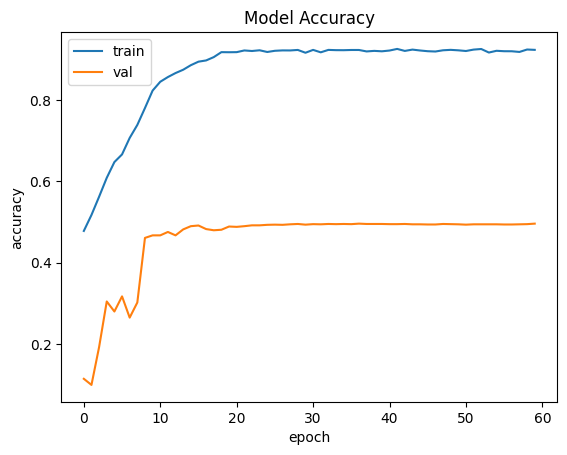

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

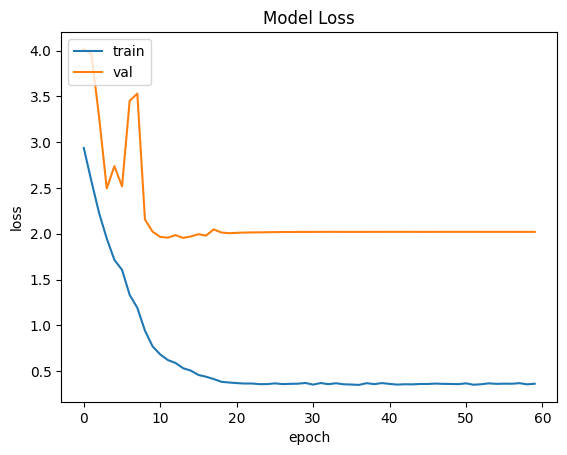

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [40]:
mobilev2model.save(os.path.join(SAVE_DIR,'mobileNetV2_FilteredReducedClasses_noPretrain_noTuning.h5'))

Training MobileNetV3 With Reduced and Filtered Data Set

In [41]:
mobilev3model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224,224,3),
    alpha=1.0,
    include_top=True,
    weights=None,
    dropout_rate=0.8,
    pooling='max'
)
mobilev3model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

In [44]:
base_learning_rate = 1e-4
opt1 = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
callback_1=tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', min_delta=0, patience=20, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

# Call back 2: 
callback_2= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
    patience=4,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

callback_list=[callback_1, callback_2]

#compiling our Model for dataset
mobilev3model.compile(optimizer=opt1,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# training the model and saving the model components history to history variable
history = mobilev3model.fit(
    train_mobilenet,
    epochs=60,
    validation_data=test_mobilenet,
    class_weight=class_weights,
    callbacks=callback_list)

Epoch 1/60
299/299 [==============================] - 48s 61ms/step - loss: 3.0636 - accuracy: 0.3961 - val_loss: 3.8105 - val_accuracy: 0.1167 - lr: 1.0000e-04
Epoch 2/60
299/299 [==============================] - 17s 57ms/step - loss: 2.6086 - accuracy: 0.4458 - val_loss: 4.8839 - val_accuracy: 0.1172 - lr: 1.0000e-04
Epoch 3/60
299/299 [==============================] - 17s 57ms/step - loss: 2.2259 - accuracy: 0.4971 - val_loss: 4.2791 - val_accuracy: 0.1272 - lr: 1.0000e-04
Epoch 4/60
299/299 [==============================] - 17s 57ms/step - loss: 1.9213 - accuracy: 0.5421 - val_loss: 4.7199 - val_accuracy: 0.1439 - lr: 1.0000e-04
Epoch 5/60
299/299 [==============================] - 17s 57ms/step - loss: 1.6380 - accuracy: 0.5994 - val_loss: 3.6288 - val_accuracy: 0.2033 - lr: 1.0000e-04
Epoch 6/60
299/299 [==============================] - 17s 58ms/step - loss: 1.4046 - accuracy: 0.6537 - val_loss: 5.1619 - val_accuracy: 0.1808 - lr: 1.0000e-04
Epoch 7/60
299/299 [==============

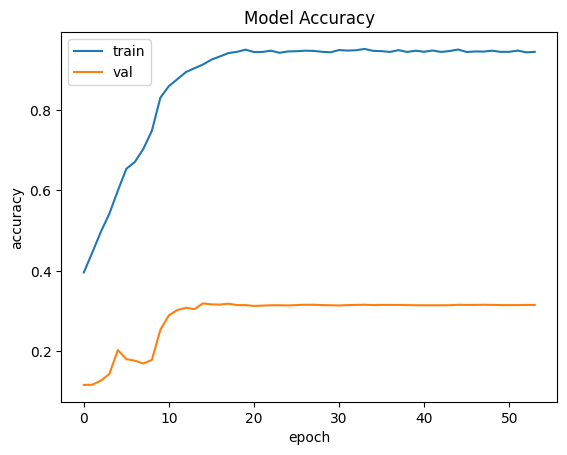

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

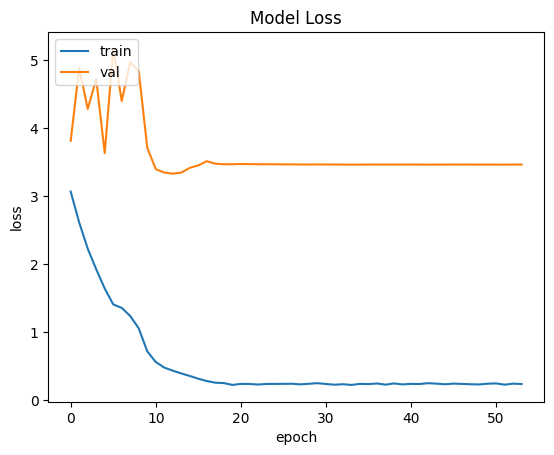

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [47]:
mobilev3model.save(os.path.join(SAVE_DIR,'mobileNetV3_FilteredReducedClasses_noPretrain_noTuning.h5'))

Iterative Pruning on Most Successful MobilNetV2 and MobileNetV3 Models

In [ ]:
!pip install -q tensorflow-model-optimization

In [94]:
import tempfile
import os
import time

import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

from tensorflow import keras
import tensorflow_model_optimization as tfmot
from keras.callbacks import ModelCheckpoint

Define Iterative Pruning Function

In [97]:
def iterative_pruning(model, initial_sparsity, final_sparsity, begin_step, end_step, train_data, test_data, class_weights, epochs):
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Define model for pruning.
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=initial_sparsity,
        final_sparsity=final_sparsity, begin_step=begin_step, end_step=end_step, frequency=50)
  }

  pruned_model = prune_low_magnitude(model, **pruning_params)
  base_learning_rate = 1e-4
  opt1 = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
  
  # prune_low_magnitude requires a recompile.
  pruned_model.compile(optimizer=opt1,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
  
  filepath = os.path.join(SAVE_DIR, 'best_pruned_model.epoch{epoch:02d}-val_acc{val_accuracy:.2f}.hdf5')
  checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    checkpoint
  ]

  pruned_model.fit(
      train_data,
      epochs=60,
      validation_data=test_data,
      class_weight=class_weights,
      callbacks=callbacks)

  return pruned_model

Attempt Iterative Pruning on Most Successful Model ('mobileNetV2_FilteredReducedClasses_noPretrain_noTuning.h5'; Initially 92.36% Training Accuracy and 49.58 Validation Accuracy)

In [98]:
 model_to_prune = tf.keras.models.load_model(os.path.join(SAVE_DIR,'mobileNetV2_FilteredReducedClasses_noPretrain_noTuning.h5'))
 fully_pruned_model = iterative_pruning(model_to_prune, 0, 0.5, 150, 240, train_mobilenet, test_mobilenet, class_weights, 60)



Epoch 1/60
299/299 [==============================] - ETA: 0s - loss: 2.8690 - accuracy: 0.6345
Epoch 1: val_accuracy improved from -inf to 0.07280, saving model to /content/drive/MyDrive/endg511project/SavedModels/best_pruned_model.epoch01-val_acc0.07.hdf5
299/299 [==============================] - 81s 84ms/step - loss: 2.8690 - accuracy: 0.6345 - val_loss: 4.4822 - val_accuracy: 0.0728
Epoch 2/60
299/299 [==============================] - ETA: 0s - loss: 4.3510 - accuracy: 0.3650
Epoch 2: val_accuracy improved from 0.07280 to 0.19916, saving model to /content/drive/MyDrive/endg511project/SavedModels/best_pruned_model.epoch02-val_acc0.20.hdf5
299/299 [==============================] - 24s 80ms/step - loss: 4.3510 - accuracy: 0.3650 - val_loss: 2.9680 - val_accuracy: 0.1992
Epoch 3/60
299/299 [==============================] - ETA: 0s - loss: 3.2992 - accuracy: 0.4684
Epoch 3: val_accuracy improved from 0.19916 to 0.25146, saving model to /content/drive/MyDrive/endg511project/SavedMode

Summary of Pruned Model

In [100]:
fully_pruned_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 prune_low_magnitude_Conv1 (Pru  (None, 112, 112, 32  1730       ['input_3[0][0]']                
 neLowMagnitude)                )                                                                 
                                                                                                  
 prune_low_magnitude_bn_Conv1 (  (None, 112, 112, 32  129        ['prune_low_magnitude_Conv1[0][0]
 PruneLowMagnitude)             )                                ']            

Apply Strip Pruning to Pruned Model

In [101]:
# Strip pruning wrappers
stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(fully_pruned_model)

In [103]:
stripped_pruned_model.save(os.path.join(SAVE_DIR,'stripped_pruned_model.h5'))

Compare Model Sizes

In [105]:
# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [107]:
print(f"Unpruned Model Size: {get_gzipped_model_size(os.path.join(SAVE_DIR,'mobileNetV2_FilteredReducedClasses_noPretrain_noTuning.h5'))}")
print(f"Pruned Model Size: {get_gzipped_model_size(os.path.join(SAVE_DIR,'stripped_pruned_model.h5'))}")

Unpruned Model Size: 24799951
Pruned Model Size: 5688732


Attempt to load best performing model failed, turned out to be a [known issue in Keras.](https://github.com/tensorflow/model-optimization/issues/206)

In [99]:
model_to_strip_prune = tf.keras.models.load_model(os.path.join(SAVE_DIR,'best_pruned_model.epoch57-val_acc0.56.hdf5'))

ValueError: ignored

In [108]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

Printout Sparsity

In [110]:
print_model_weights_sparsity(stripped_pruned_model)

Conv1/kernel:0: 45.60% sparsity  (394/864)
expanded_conv_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/288)
expanded_conv_project/kernel:0: 45.70% sparsity  (234/512)
block_1_expand/kernel:0: 45.64% sparsity  (701/1536)
block_1_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/864)
block_1_project/kernel:0: 45.62% sparsity  (1051/2304)
block_2_expand/kernel:0: 45.60% sparsity  (1576/3456)
block_2_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1296)
block_2_project/kernel:0: 45.60% sparsity  (1576/3456)
block_3_expand/kernel:0: 45.60% sparsity  (1576/3456)
block_3_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1296)
block_3_project/kernel:0: 45.62% sparsity  (2102/4608)
block_4_expand/kernel:0: 45.61% sparsity  (2802/6144)
block_4_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1728)
block_4_project/kernel:0: 45.61% sparsity  (2802/6144)
block_5_expand/kernel:0: 45.61% sparsity  (2802/6144)
block_5_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1728)
block_5_project/kernel:0: 4

One Shot Sparsity

In [89]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
## Print weights before and after

# Define model for pruning. The 0.5 is the target sparsity (50%)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100)
}

pruned_model_one_shot = prune_low_magnitude(model_to_prune, **pruning_params)

# prune_low_magnitude requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
pruned_model_one_shot.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

pruned_model_one_shot.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 prune_low_magnitude_Conv1 (Pru  (None, 112, 112, 32  1730       ['input_3[0][0]']                
 neLowMagnitude)                )                                                                 
                                                                                                  
 prune_low_magnitude_bn_Conv1 (  (None, 112, 112, 32  129        ['prune_low_magnitude_Conv1[0][0]
 PruneLowMagnitude)             )                                ']            

One Shot Sparsity appears to have failed

In [111]:
print_model_weights_sparsity(pruned_model_one_shot)

Conv1/kernel:0: 0.00% sparsity  (0/864)
expanded_conv_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/288)
expanded_conv_project/kernel:0: 0.00% sparsity  (0/512)
block_1_expand/kernel:0: 0.00% sparsity  (0/1536)
block_1_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/864)
block_1_project/kernel:0: 0.00% sparsity  (0/2304)
block_2_expand/kernel:0: 0.00% sparsity  (0/3456)
block_2_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1296)
block_2_project/kernel:0: 0.00% sparsity  (0/3456)
block_3_expand/kernel:0: 0.00% sparsity  (0/3456)
block_3_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1296)
block_3_project/kernel:0: 0.00% sparsity  (0/4608)
block_4_expand/kernel:0: 0.00% sparsity  (0/6144)
block_4_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1728)
block_4_project/kernel:0: 0.00% sparsity  (0/6144)
block_5_expand/kernel:0: 0.00% sparsity  (0/6144)
block_5_depthwise/depthwise_kernel:0: 0.00% sparsity  (0/1728)
block_5_project/kernel:0: 0.00% sparsity  (0/6144)
block_6_expand/ke

## Discussion of Implementation and Results


To summarize, there was great difficulty in developing an initial model with good validation accuracy. All the combinations of models and alterations include:
* AlexNet
  * Full VMMRdb data set with ~9000 classes
    * Top 1 Categorical Accuracy
    * Top 22 Categorical Accuracy
    * Top 200 Categorical Accuracy
  * Combining Years into Make/Model Classes With Minimum 100 Images Per Class(363 Classes Total)
    * Top 1 Categorical Accuracy
    * Top 10 Categorical Accuracy
* MobileNetV2 & MobileNetV3 (Large)
  * Reduced data set that included classes only with >=400 images (25 classes total)
    * Accuracy only (top k categorical accuracy wasn't used because of the significant reduction in number of classes)
    * Hyperparameter tuning, data augmentation, regularization (many combinations attempted), including:
      * Rescaling, rotation, zoom, width/height shifting, shearing, flipping.
      * Pretrained weights from ImageNet (unfrozen)
      * L2 Regularization
      * Hyperparameter adjustments attempted:
        * Max/Avergage/None pooling
        * Alpha between 1 and 3
        * Dropout rate between 0.5 and 1
        * Adding more ReLu/Convolutional 2D layers
        * Epochs between 30 and 100
        * Initial learning rate between 1e-1 and 1e-10
  * Combining 'Year' to Make/Model classes (12 in total)
    * Increased number of epochs between 60-180 (through re-running the same code set to 60 epochs).

Through all of these considerations, the maximum validation accuracy that could be achieved was approximately 50%. 

## Challenges

There were several challenges with this project, mainly with what was assumed to be the 'easy' part (loading a data set into Google Colab, and getting a decent accuracy on a base model). 

The size of the data set proved to be too much for the free tier of Google Colab, and required Google Plus compute credits so the full data set could be loaded into the RAM. Prior to upgrading, the data set was uploaded to a Google Drive account and attempted to be read from there, however this resulted in extremely long read times (again due to the size of the data set, but also due to the slow read/write speeds of Google Colab from/to Google Drive).

Once the VMMRdb was able to be loaded into the Google Colab runtime (with a Google Colab Plus account), the next problem became training the AlexNet model. It took an extremely long time to train and heavily used compute credits.

Though the data set had many images (nearly 300,000), There were also many classes (8,174), which made the average number of images per class very low (approx. 34 images per class). While training the AlexNet model was attempted with the full set of images and classes, it should be noted that most papers that used this data set ended up using only the classes that had a large number of images [2][3]. For this reason and the other problems encountered (above), we decided to pivot into using a subsection of the data set and also use a smaller model like the MobileNets.

This pivot proved to be better; training accuracy was able to reach greater than 90% on most occasions (provided training lasted for enough epochs; this was usually in the 100-200 epoch range, but training was performed in groups of 60 epochs, then recomputed if the model seemed like it hadn't plateued yet). Unfortunately, validation accuracy was difficult to improve. There were many techniques attempted, as listed above in the 'Discussion of Implementation and Results' section, however the greated validation accuracy that could be achieved was just approximately 56%.

After this model was saved, it was attempted to be pruned. Following the code from the lab, iterative pruning was successful, but a known keras issue was encountered when trying to use checkpointing in combination with iterative pruning (to preserve the best performing model). One shot pruning appeared to be unsuccessful, and time ran out to continue troubleshooting.

## Discussion of Results

Overall, the main purpose of this project was to explore the feasibility of using a lightweight CNN model to process dashcam data for vehicle make/model/year identification. After the significant amount of problems encountered in this project, it is clear that this task may be too large of a scope for a small scale (compressed) CNN as originally envisioned. We chose the VMMRdb as the data set, mainly because we felt it to be most representative of the diversity of vehicles a dashcam would be exposed to in the real world. Given the huge diversity of vehicles on the road today, it may be more practical for a dashcam vehicle identifier to focus on a limited number of classes of vehicles.

## Future Work

Future improvements include better sorting of the dataset, colour augmentation and implementation of other algorithms, such as the YOLO Architecture for better detection of vehicles within a "busy" image with other objects present. 

With colour augmentation, the intention would be to set images to grayscale, and thus force the model to classify the vehicles based off their size and shape rather than colour. This could rule out the potential suspicion that the colour of the vehicles is somehow contirbuting to the confusion and poor classifications of the model. 

In addition, upon further researching into the task itself, the YOLO architecture may be favourable for the variety of images in this task. Originally this architecture was not pursued as most images appeared to be relatively "isolated" and the main focal point of the image. However, with YOLO, perhaps the model could better deal with the variety of backgrounds (streets, garages etc), as well as angles from which the image is taken. 

An immediate next step could also include going back to the AlexNet model and using the reduced and filtered dataset to re-train the model. This step was omitted due to lack of time and compute credits available to compile the large AlexNet model.

Lastly, a data set that identifies only a portion of the vehicle from a standard view (e.g. rear view only) may be a more practical approach, rather than a data set that includes vehicles from all angles. This may allow the CNN to make better distinctions between features that belong to each class.

## References

[1] 	F. Tafazzoli, H. Frigui and K. Nishiyama, "A Large and Diverse Dataset for Improved Vehicle Make and Model Recognition," in Conference on Computer Vision and Patter Recognition (CVPR), Honolulu, Hawaii, 2017. 

[2]   Krizhevsky, A., Sutskever, I., and Hinton, G. E. ImageNet classification
with deep convolutional neural networks. In NIPS, pp. 1106–1114, 2012.

[3] Kristiani, E., Yang, C. T., & Huang, C. Y. (2020). iSEC: an optimized deep learning model for image classification on edge computing. IEEE Access, 8, 27267-27276.